In [1]:
!pip install bitsandbytes peft trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 24.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.6/504.6 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os 

from datasets import load_dataset 
import torch 
from transformers import Qwen2VLForConditionalGeneration,Qwen2VLProcessor,BitsAndBytesConfig
from peft import LoraConfig,get_peft_model
from trl import SFTConfig , SFTTrainer

import warnings 
warnings.filterwarnings("ignore")

2025-08-03 05:19:27.980322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754198368.313349      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754198368.406202      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

base_model ="Qwen/Qwen2-VL-7B-Instruct"
epochs =1
batch_size=1
gradient_checkpointing=True 
use_reentrant=True
optimizer = "paged_adamw_32bit"
lr = 2e-5
logging_steps = 50 
eval_steps = 50
save_steps = 50 
eval_strat = "steps"
save_strat= "steps"
metric_for_best = "eval_loss"
load_best = True
max_grad = 1
WARMUP = 0
DATA_KWARGS={"skip_prepare_dataset": True} 
rem_unused = False 
max_len=128
num_steps = (283 // batch_size) * epochs
print(f"NUM_STEPS: {num_steps}")

cuda
NUM_STEPS: 283


In [4]:
message =""" Analyze the provided image ,a model trained to detect fake visuals detected it as FAKE . Identify and explain artifacts that indicate it is fake. Focus primarily on the original image to identify and explain distinguishing artifacts that indicate it is fake. Provide clear, concise explanations (maximum 50 words each) using the specified artifacts below. Include positional references like 'top left' or 'bottom right' when relevant. DO NOT include any other sentences or artifacts in your response. Select only 6-7 relevant artifacts.
make prediction of the category of the image. 
Output Format:
Write each artifact and explanation on a separate line, using the format:
Artifact Name: Explanation.
For example:
Notes:
Explanations should remain under 50 words for clarity.
AVOID referencing artifacts not listed or including extra commentary.

"""  

def format_data(data):
    return [
        {"role":"user",
        "content":[{"type":"image","image":data["image"]},{"type":"text","text":message},],
        },
        
        {"role":"assistant",
        "content":[{"type":"text","text":data["answer"]}],
        },
    ]

In [5]:
traindata = load_dataset(
    "22-24/AI_Image_Artifacts_Present",split="train[:1%]"
)


README.md:   0%|          | 0.00/326 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/36 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/36 [00:00<?, ?it/s]

train-00000-of-00036.parquet:   0%|          | 0.00/791M [00:00<?, ?B/s]

train-00001-of-00036.parquet:   0%|          | 0.00/742M [00:00<?, ?B/s]

train-00002-of-00036.parquet:   0%|          | 0.00/737M [00:00<?, ?B/s]

train-00003-of-00036.parquet:   0%|          | 0.00/720M [00:00<?, ?B/s]

train-00004-of-00036.parquet:   0%|          | 0.00/700M [00:00<?, ?B/s]

train-00005-of-00036.parquet:   0%|          | 0.00/673M [00:00<?, ?B/s]

train-00006-of-00036.parquet:   0%|          | 0.00/815M [00:00<?, ?B/s]

train-00007-of-00036.parquet:   0%|          | 0.00/681M [00:00<?, ?B/s]

train-00008-of-00036.parquet:   0%|          | 0.00/647M [00:00<?, ?B/s]

train-00009-of-00036.parquet:   0%|          | 0.00/668M [00:00<?, ?B/s]

train-00010-of-00036.parquet:   0%|          | 0.00/695M [00:00<?, ?B/s]

train-00011-of-00036.parquet:   0%|          | 0.00/567M [00:00<?, ?B/s]

train-00012-of-00036.parquet:   0%|          | 0.00/174M [00:00<?, ?B/s]

train-00013-of-00036.parquet:   0%|          | 0.00/164M [00:00<?, ?B/s]

train-00014-of-00036.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

train-00015-of-00036.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

train-00016-of-00036.parquet:   0%|          | 0.00/161M [00:00<?, ?B/s]

train-00017-of-00036.parquet:   0%|          | 0.00/160M [00:00<?, ?B/s]

train-00018-of-00036.parquet:   0%|          | 0.00/176M [00:00<?, ?B/s]

train-00019-of-00036.parquet:   0%|          | 0.00/155M [00:00<?, ?B/s]

train-00020-of-00036.parquet:   0%|          | 0.00/152M [00:00<?, ?B/s]

train-00021-of-00036.parquet:   0%|          | 0.00/161M [00:00<?, ?B/s]

train-00022-of-00036.parquet:   0%|          | 0.00/163M [00:00<?, ?B/s]

train-00023-of-00036.parquet:   0%|          | 0.00/139M [00:00<?, ?B/s]

train-00024-of-00036.parquet:   0%|          | 0.00/652M [00:00<?, ?B/s]

train-00025-of-00036.parquet:   0%|          | 0.00/704M [00:00<?, ?B/s]

train-00026-of-00036.parquet:   0%|          | 0.00/664M [00:00<?, ?B/s]

train-00027-of-00036.parquet:   0%|          | 0.00/606M [00:00<?, ?B/s]

train-00028-of-00036.parquet:   0%|          | 0.00/564M [00:00<?, ?B/s]

train-00029-of-00036.parquet:   0%|          | 0.00/580M [00:00<?, ?B/s]

train-00030-of-00036.parquet:   0%|          | 0.00/622M [00:00<?, ?B/s]

train-00031-of-00036.parquet:   0%|          | 0.00/590M [00:00<?, ?B/s]

train-00032-of-00036.parquet:   0%|          | 0.00/565M [00:00<?, ?B/s]

train-00033-of-00036.parquet:   0%|          | 0.00/579M [00:00<?, ?B/s]

train-00034-of-00036.parquet:   0%|          | 0.00/614M [00:00<?, ?B/s]

train-00035-of-00036.parquet:   0%|          | 0.00/552M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [6]:
print(len(traindata))

150


In [7]:
print(traindata[0]["image"])

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024 at 0x7EA03E9D7B90>


In [8]:
traindata2= traindata[:51]
traindata2 = [format_data(data) for data in traindata]

In [9]:
traindata2[0]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>},
   {'type': 'text',
    'text': " Analyze the provided image ,a model trained to detect fake visuals detected it as FAKE . Identify and explain artifacts that indicate it is fake. Focus primarily on the original image to identify and explain distinguishing artifacts that indicate it is fake. Provide clear, concise explanations (maximum 50 words each) using the specified artifacts below. Include positional references like 'top left' or 'bottom right' when relevant. DO NOT include any other sentences or artifacts in your response. Select only 6-7 relevant artifacts.\nmake prediction of the category of the image. \nOutput Format:\nWrite each artifact and explanation on a separate line, using the format:\nArtifact Name: Explanation.\nFor example:\nNotes:\nExplanations should remain under 50 words for clarity.\nAVOID referencing artifacts not listed or including e

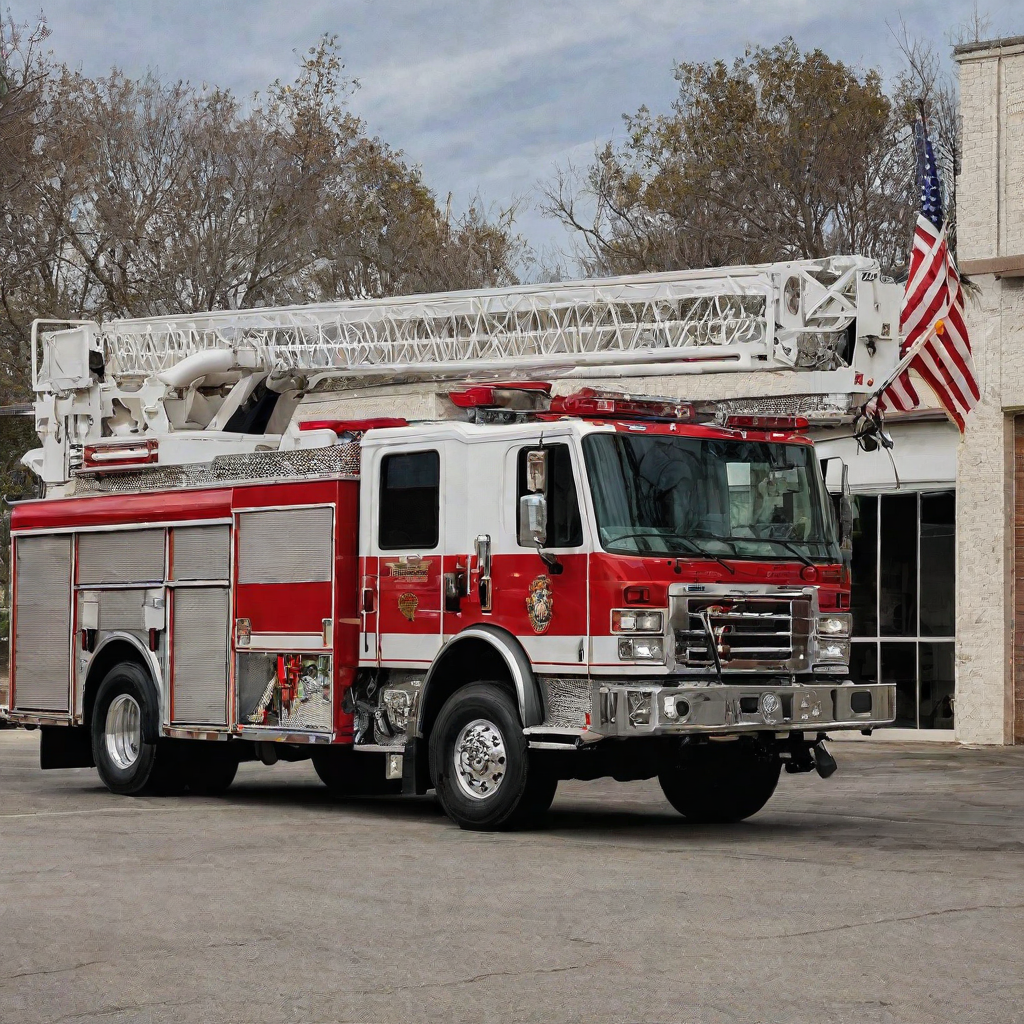

In [10]:
traindata2[0][0]["content"][0]["image"]

In [11]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type= "nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = Qwen2VLForConditionalGeneration.from_pretrained(
    base_model,
    device_map = "auto",
    quantization_config = bnb_config,
    use_cache=False
)
processor = Qwen2VLProcessor.from_pretrained(base_model)
processor.tokenizer.padding_side  = "right"

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

In [19]:
from transformers import TextStreamer


def text_generator(data):
    text = processor.apply_chat_template([data[0]], add_generation_prompt=True, tokenize=False)
    print(f"Prompt:\n{text}")
    image_inputs = data[0]["content"][0]["image"]

   
    inputs = processor(text=[text], images=[image_inputs], return_tensors="pt").to(model.device)

    

    streamer = TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True)
    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=max_len,streamer=streamer)

    
    input_ids = inputs.input_ids
    generated = [gen_ids[len(inp_ids):] for inp_ids, gen_ids in zip(input_ids, generated_ids)]

    
    output = processor.batch_decode(generated, skip_special_tokens=True)


    target = data[1]["content"][0]["text"]

    return output[0], target


In [20]:
print(model.device)


cuda:0


In [21]:
gen ,act = text_generator(traindata2[0])
print(f"gen:{gen}")
print("-"*30)
print(f"act:{act}")

Prompt:
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|> Analyze the provided image ,a model trained to detect fake visuals detected it as FAKE . Identify and explain artifacts that indicate it is fake. Focus primarily on the original image to identify and explain distinguishing artifacts that indicate it is fake. Provide clear, concise explanations (maximum 50 words each) using the specified artifacts below. Include positional references like 'top left' or 'bottom right' when relevant. DO NOT include any other sentences or artifacts in your response. Select only 6-7 relevant artifacts.
make prediction of the category of the image. 
Output Format:
Write each artifact and explanation on a separate line, using the format:
Artifact Name: Explanation.
For example:
Notes:
Explanations should remain under 50 words for clarity.
AVOID referencing artifacts not listed or including extra commentary.

<|im_end|>
<|im_start|>ass

In [22]:
print("done")

done


In [23]:
peft_config=LoraConfig(
    lora_alpha=16,
    r=8,
    bias="none",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)
peft_model = get_peft_model(model,peft_config)
peft_model.print_trainable_parameters()

trainable params: 20,185,088 || all params: 8,311,560,704 || trainable%: 0.2429


In [39]:
from trl import SFTConfig

training_args = SFTConfig(
    output_dir="./output",
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    gradient_checkpointing=gradient_checkpointing,
    learning_rate=lr,
    logging_steps=logging_steps,
    max_grad_norm=max_grad,
    warmup_steps=WARMUP,
    dataset_kwargs=DATA_KWARGS,                   
    remove_unused_columns=rem_unused,
    optim=optimizer,  
    disable_tqdm=False,
    report_to=[],  # Optional: disables logging to services like WandB
)


In [40]:
collate_sample = [traindata2[0],traindata2[1]]

def collate_fn(sample):
    text = [processor.apply_chat_template(t,tokenize=False) for t in sample]
    image_inputs= [t[0]["content"][0]["image"] for t in sample]

    batch = processor(
        text = text, images = image_inputs,return_tensors = "pt",padding=True 
    )

    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100
    batch["labels"]=labels

    return batch 

In [41]:
collated_data = collate_fn(collate_sample)
print(collated_data.keys())

KeysView({'input_ids': tensor([[151644,   8948,    198,  ..., 151643, 151643, 151643],
        [151644,   8948,    198,  ...,     92, 151645,    198]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]]), 'pixel_values': tensor([[ 0.4851,  0.4997,  0.5289,  ...,  1.3069,  1.2785,  1.3069],
        [ 0.5581,  0.5289,  0.5289,  ...,  1.3069,  1.2785,  1.2500],
        [-0.0842,  0.7041,  0.6019,  ...,  1.2358,  0.1266,  0.5106],
        ...,
        [-0.4346, -0.4054, -0.3762,  ..., -0.3142, -0.1009, -0.3568],
        [-0.5660, -0.5660, -0.5076,  ..., -0.4564, -0.4990, -0.4137],
        [-0.5660, -0.5952, -0.6244,  ..., -0.2573, -0.3000, -0.3853]]), 'image_grid_thw': tensor([[ 1, 74, 74],
        [ 1, 74, 74]]), 'labels': tensor([[151644,   8948,    198,  ...,   -100,   -100,   -100],
        [151644,   8948,    198,  ...,     92, 151645,    198]])})


In [42]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=traindata2,
    data_collator=collate_fn,
    peft_config=peft_config,
    processing_class=processor.tokenizer,
)

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [43]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


TrainOutput(global_step=150, training_loss=9.373998006184896, metrics={'train_runtime': 8301.1032, 'train_samples_per_second': 0.018, 'train_steps_per_second': 0.018, 'total_flos': 1.3029699232232448e+16, 'train_loss': 9.373998006184896})

In [44]:
save_dir = "/kaggle/working/qwen_trained_model"


os.makedirs(save_dir, exist_ok=True)

model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

[]

In [46]:
import shutil

# To zip a directory (e.g., 'qwen-finetuned')
shutil.make_archive('/kaggle/working/qwen2_7b_finetuned', 'zip', '/kaggle/working/output/checkpoint-150')


'/kaggle/working/qwen2_7b_finetuned.zip'

In [47]:
traindata2[0]

[{'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>},
   {'type': 'text',
    'text': " Analyze the provided image ,a model trained to detect fake visuals detected it as FAKE . Identify and explain artifacts that indicate it is fake. Focus primarily on the original image to identify and explain distinguishing artifacts that indicate it is fake. Provide clear, concise explanations (maximum 50 words each) using the specified artifacts below. Include positional references like 'top left' or 'bottom right' when relevant. DO NOT include any other sentences or artifacts in your response. Select only 6-7 relevant artifacts.\nmake prediction of the category of the image. \nOutput Format:\nWrite each artifact and explanation on a separate line, using the format:\nArtifact Name: Explanation.\nFor example:\nNotes:\nExplanations should remain under 50 words for clarity.\nAVOID referencing artifacts not listed or including e

In [61]:
from transformers import TextStreamer


def text_generator(data):
    text = processor.apply_chat_template([data[0]], add_generation_prompt=True, tokenize=False)
    print(f"Prompt:\n{text}")
    image_inputs = data[0]["content"][0]["image"]

   
    inputs = processor(text=[text], images=[image_inputs], return_tensors="pt").to(model.device)

    
    #inputs = {k: v.to(dtype=torch.bfloat16) if torch.is_floating_point(v) else v for k, v in inputs.items()}


    streamer = TextStreamer(processor.tokenizer, skip_prompt=True, skip_special_tokens=True)
    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=max_len,streamer=streamer)

    
    input_ids = inputs.input_ids
    generated = [gen_ids[len(inp_ids):] for inp_ids, gen_ids in zip(input_ids, generated_ids)]

    
    output = processor.batch_decode(generated, skip_special_tokens=True)


    target = data[1]["content"][0]["text"]

    return output[0], target


In [56]:
bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
model = Qwen2VLForConditionalGeneration.from_pretrained(
        base_model, 
        device_map="auto", 
        quantization_config=bnb_config,
        use_cache=True
        )

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [60]:
model = PeftModel.from_pretrained(model, "/kaggle/working/output/checkpoint-150")
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-31): 32 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): Linear4bit(in_features=1280, out_features=3840, bias=True)
                (proj): Linear4bit(in_features=1280, out_features=1280, bias=True)
              )
              (mlp): VisionMlp(
                (fc1): Linear4bit(in_features=1280, out_features=5120, bias=True)
                (act): QuickGELUActivation()
             

In [62]:
gen ,act = text_generator(traindata2[0])
print(f"gen:{gen}")
print("-"*30)
print(f"act:{act}")

Prompt:
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|> Analyze the provided image ,a model trained to detect fake visuals detected it as FAKE . Identify and explain artifacts that indicate it is fake. Focus primarily on the original image to identify and explain distinguishing artifacts that indicate it is fake. Provide clear, concise explanations (maximum 50 words each) using the specified artifacts below. Include positional references like 'top left' or 'bottom right' when relevant. DO NOT include any other sentences or artifacts in your response. Select only 6-7 relevant artifacts.
make prediction of the category of the image. 
Output Format:
Write each artifact and explanation on a separate line, using the format:
Artifact Name: Explanation.
For example:
Notes:
Explanations should remain under 50 words for clarity.
AVOID referencing artifacts not listed or including extra commentary.

<|im_end|>
<|im_start|>ass

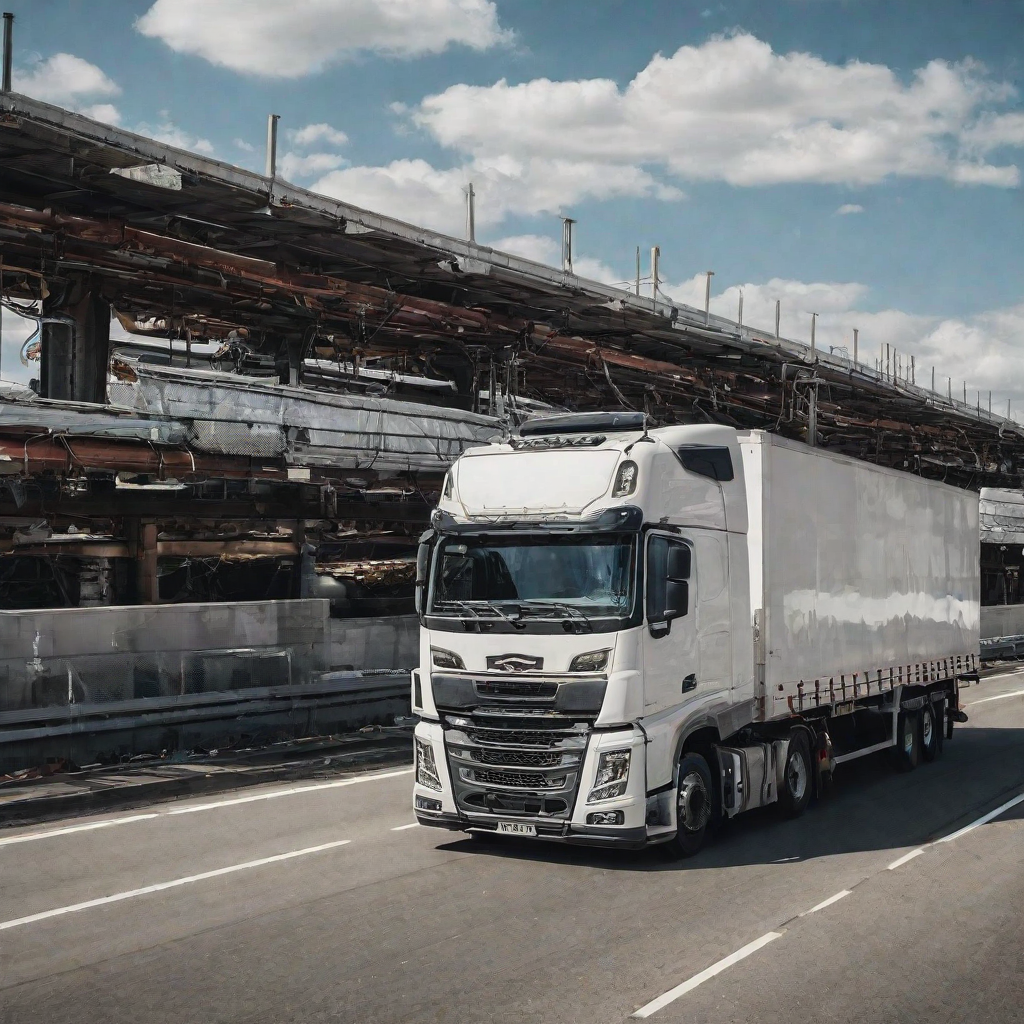

In [63]:
traindata2[1][0]["content"][0]["image"]

In [64]:
gen ,act = text_generator(traindata2[1])
print(f"gen:{gen}")
print("-"*30)
print(f"act:{act}")

Prompt:
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|> Analyze the provided image ,a model trained to detect fake visuals detected it as FAKE . Identify and explain artifacts that indicate it is fake. Focus primarily on the original image to identify and explain distinguishing artifacts that indicate it is fake. Provide clear, concise explanations (maximum 50 words each) using the specified artifacts below. Include positional references like 'top left' or 'bottom right' when relevant. DO NOT include any other sentences or artifacts in your response. Select only 6-7 relevant artifacts.
make prediction of the category of the image. 
Output Format:
Write each artifact and explanation on a separate line, using the format:
Artifact Name: Explanation.
For example:
Notes:
Explanations should remain under 50 words for clarity.
AVOID referencing artifacts not listed or including extra commentary.

<|im_end|>
<|im_start|>ass

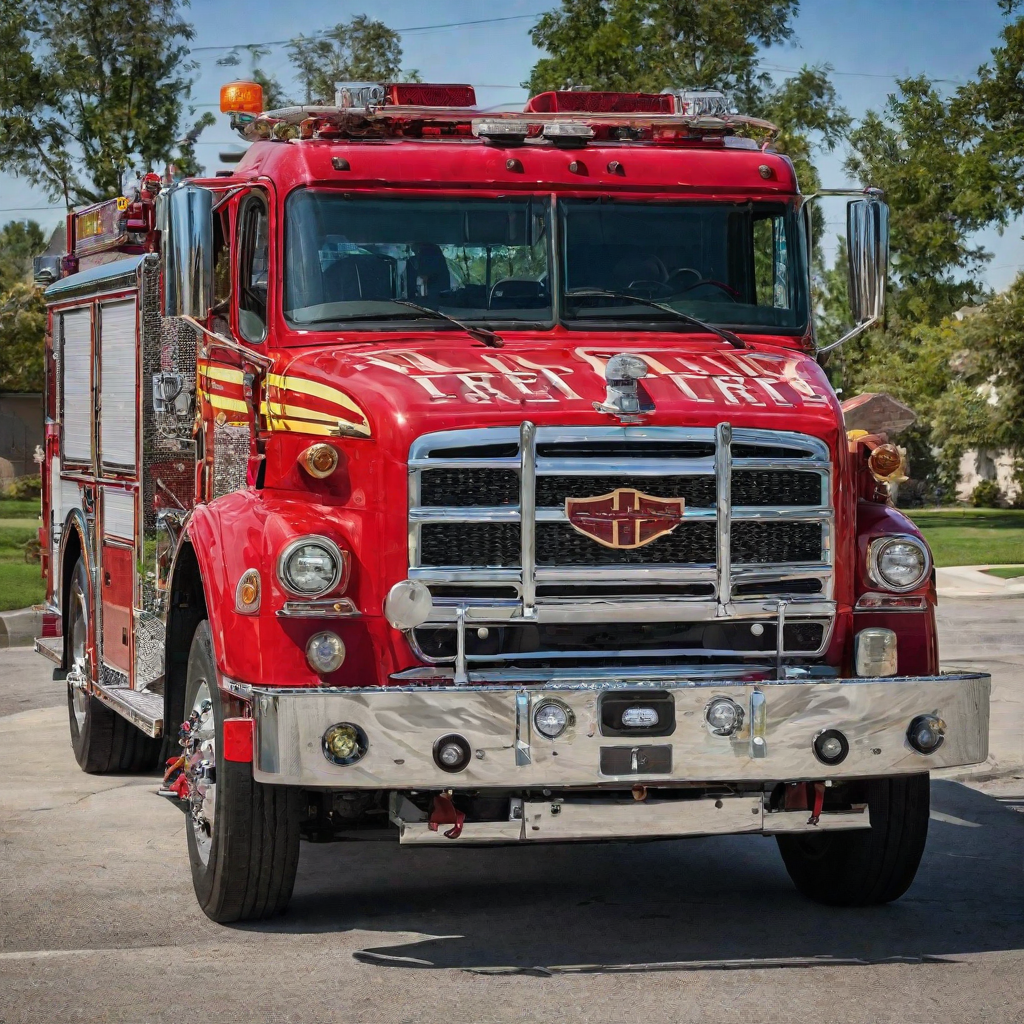

In [65]:
traindata2[2][0]["content"][0]["image"]

In [66]:
gen ,act = text_generator(traindata2[2])
print(f"gen:{gen}")
print("-"*30)
print(f"act:{act}")

Prompt:
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|> Analyze the provided image ,a model trained to detect fake visuals detected it as FAKE . Identify and explain artifacts that indicate it is fake. Focus primarily on the original image to identify and explain distinguishing artifacts that indicate it is fake. Provide clear, concise explanations (maximum 50 words each) using the specified artifacts below. Include positional references like 'top left' or 'bottom right' when relevant. DO NOT include any other sentences or artifacts in your response. Select only 6-7 relevant artifacts.
make prediction of the category of the image. 
Output Format:
Write each artifact and explanation on a separate line, using the format:
Artifact Name: Explanation.
For example:
Notes:
Explanations should remain under 50 words for clarity.
AVOID referencing artifacts not listed or including extra commentary.

<|im_end|>
<|im_start|>ass